In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay,  mean_squared_error, log_loss
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import math

from scipy.stats import ks_2samp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

Mounted at /content/drive


In [ ]:
X_train = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
y_train = pd.read_csv(f"{DATA_DIR}/y_train_over.csv").values.ravel()

X_val = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
y_val = pd.read_csv(f"{DATA_DIR}/y_val_over.csv").values.ravel()

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv").values.ravel()

In [ ]:
def ks_score(y_true, y_prob):
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()

    prob_1 = y_prob[y_true == 1]
    prob_0 = y_prob[y_true == 0]

    return ks_2samp(prob_1, prob_0).statistic


In [ ]:
def classification_metrics(y_true, y_prob, threshold=0.5):
    y_true = np.asarray(y_true).ravel()
    y_prob = np.asarray(y_prob).ravel()
    y_pred = (y_prob >= threshold).astype(int)

    # Nomes rigorosamente alinhados ao slide 11 do projeto
    metrics = {
        "KS": ks_score(y_true, y_prob),
        "AUROC": roc_auc_score(y_true, y_prob), # O nome é AUROC
        "F-Measure": f1_score(y_true, y_pred, zero_division=0),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "Accuracy": accuracy_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_prob),
        "LogLoss": log_loss(y_true, y_prob),
        "ConfusionMatrix": confusion_matrix(y_true, y_pred)
    }

    return metrics

In [ ]:
def build_mlp(input_dim,
              n_layers=1,
              n_units=10,
              activation='relu',
              dropout=0.0,
              learning_rate=0.001):

    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for _ in range(n_layers):
        model.add(Dense(n_units, activation=activation))
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy'
    )

    return model

In [ ]:
def train_and_evaluate(model,
                       X_train, y_train,
                       X_val, y_val,
                       X_test, y_test,
                       epochs=10000,
                       batch_size=64):

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Probabilidades
    y_train_prob = model.predict(X_train).ravel()
    y_val_prob   = model.predict(X_val).ravel()
    y_test_prob  = model.predict(X_test).ravel()

    results = {
        "train": classification_metrics(y_train, y_train_prob),
        "val":   classification_metrics(y_val, y_val_prob),
        "test":  classification_metrics(y_test, y_test_prob)
    }

    return results, history

In [ ]:
def optuna_objective(trial,
                     X_train, y_train,
                     X_val, y_val):

    # ==========================
    # Parâmetros VARIÁVEIS
    # ==========================
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 5, 50)
    activation = trial.suggest_categorical(
        "activation", ["relu", "tanh"]
    )
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float(
        "learning_rate", 1e-4, 1e-2, log=True
    )

    # ==========================
    # Modelo
    # ==========================
    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=n_layers,
        n_units=n_units,
        activation=activation,
        dropout=dropout,
        learning_rate=learning_rate
    )

    # ==========================
    # Treinamento (FIXO)
    # ==========================
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10000,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # ==========================
    # Avaliação (KS)
    # ==========================
    y_val_prob = model.predict(X_val).ravel()
    ks = ks_score(y_val, y_val_prob)

    return ks

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return roc_auc


In [ ]:
def plot_ks_cumulative(y_true, y_score, title="Curva KS"):
    """
    Plota a Curva KS no formato cumulativo clássico:
    - TPR acumulado (positivos)
    - FPR acumulado (negativos)
    """

    y_true = np.asarray(y_true).ravel()
    y_score = np.asarray(y_score).ravel()

    # Ordena pelo score decrescente
    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]

    # Quantidade total de positivos e negativos
    n_pos = np.sum(y_sorted == 1)
    n_neg = np.sum(y_sorted == 0)

    # Cumulativos
    cum_pos = np.cumsum(y_sorted == 1) / n_pos
    cum_neg = np.cumsum(y_sorted == 0) / n_neg

    # KS
    diff = np.abs(cum_pos - cum_neg)
    ks = np.max(diff)
    ks_pos = np.argmax(diff)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(cum_pos, label="TPR (Cumulativo)")
    plt.plot(cum_neg, label="FPR (Cumulativo)")
    plt.axvline(
        ks_pos,
        color="red",
        linestyle="--",
        label=f"KS = {ks:.3f}"
    )
    plt.xlabel("Amostras ordenadas pelo score")
    plt.ylabel("Taxa acumulada")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return ks


In [ ]:
def plot_confusion_matrix(y_true, y_prob, title, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False
    )
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(title)
    plt.show()


# Experimento 1 - Modelo Base

In [ ]:
model = build_mlp(
    input_dim=X_train.shape[1],
    n_units=10,
    learning_rate=0.001,
    dropout=0.2
)

# =====================
# 6. Treinamento
# =====================
results, history = train_and_evaluate(
    model,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)

for split, metrics in results.items():
    print(f"\n📌 {split.upper()}")
    print(f"Accuracy : {metrics['Accuracy']:.4f}")
    print(f"MSE      : {metrics['MSE']:.4f}")
    print(f"LogLoss  : {metrics['LogLoss']:.4f}")
    print(f"AUROC      : {metrics['AUROC']:.4f}")
    print(f"KS       : {metrics['KS']:.4f}")
    print("Confusion Matrix:")
    print(metrics["ConfusionMatrix"])


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

📌 TRAIN
Accuracy : 0.7790
MSE      : 0.1522
LogLoss  : 0.4640
AUROC      : 0.8585
KS       : 0.5681
Confusion Matrix:
[[1867  710]
 [ 429 2148]]

📌 VAL
Accuracy : 0.7675
MSE      : 0.1606
LogLoss  : 0.4912
AUROC      : 0.8432
KS       : 0.5419
Confusion Matrix:
[[ 954  334]
 [ 265 1023]]

📌 TEST
Accuracy : 0.7467
MSE      : 0.1619
LogLoss  : 0.4825
AUROC      : 0.8530
KS       : 0.5338
Confusion Matrix:
[[942 346]
 [ 98 367]]


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


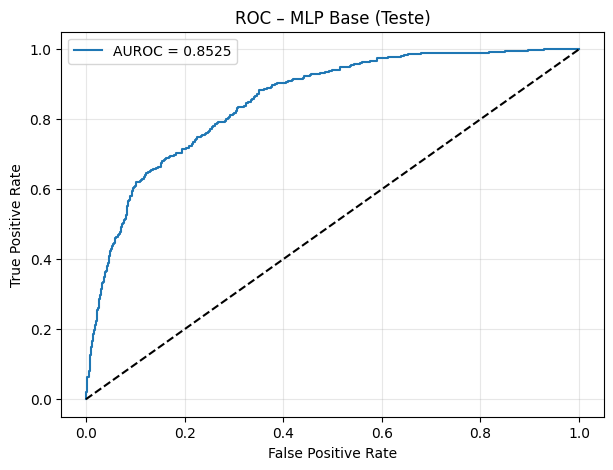

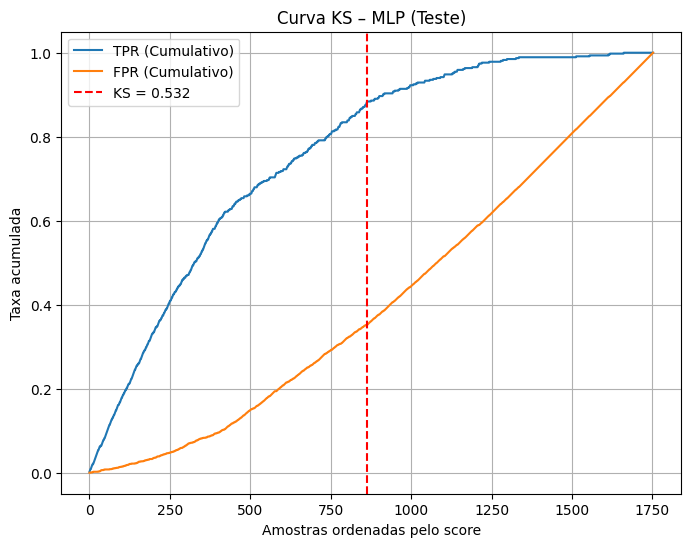

KS Teste: 0.5322


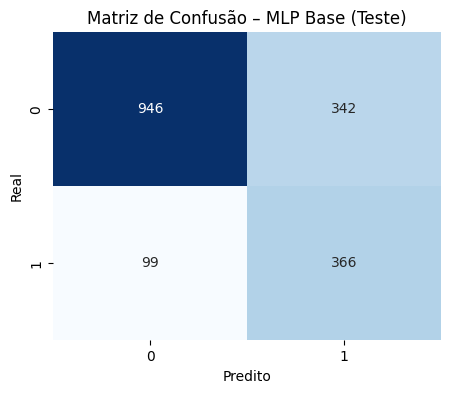

In [ ]:
y_test_prob = model.predict(X_test).ravel()

plot_roc(
    y_test,
    y_test_prob,
    title="ROC – MLP Base (Teste)"
)

ks_test = plot_ks_cumulative(
    y_test,
    y_test_prob,
    title="Curva KS – MLP (Teste)"
)

print(f"KS Teste: {ks_test:.4f}")


plot_confusion_matrix(
    y_test,
    y_test_prob,
    title="Matriz de Confusão – MLP Base (Teste)"
)


# Experimento 2 - Otimização dos hiperparametros - Função de ativação

##Teste da função sigmoide

In [ ]:
def optuna_objective_sigmoid(trial, X_train, y_train, X_val, y_val):
    # Parâmetros que continuam variando
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 5, 50)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # FUNÇÃO FIXADA: Atende ao requisito de "logística" do projeto
    activation = "sigmoid"

    # Construção do modelo com a ativação fixa
    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=n_layers,
        n_units=n_units,
        activation=activation,
        dropout=dropout,
        learning_rate=learning_rate
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20, # Patience conforme sugerido no slide 27 [cite: 420]
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10000, # Limite de épocas do projeto [cite: 384, 418]
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_val_prob = model.predict(X_val).ravel()
    ks = ks_score(y_val, y_val_prob) # KS é a métrica principal

    return ks

##Primeira trial Sigmoide



In [ ]:
# Cria o estudo para maximizar o KS
study_sigmoid = optuna.create_study(direction="maximize")

# Executa exatamente 25 tentativas
study_sigmoid.optimize(
    lambda trial: optuna_objective_sigmoid(trial, X_train, y_train, X_val, y_val),
    n_trials=25
)

# Salva o histórico de todos os trials em um CSV
df_sigmoid_results = study_sigmoid.trials_dataframe()
df_sigmoid_results.to_csv("trials_sigmoid_churn.csv", index=False)

print("\n✅ Experimento Concluído!")
print(f"Melhor KS obtido: {study_sigmoid.best_value:.4f}")
print("Os resultados de cada trial foram salvos em 'trials_sigmoid_churn.csv'")

[I 2025-12-19 15:48:31,574] A new study created in memory with name: no-name-056b23a2-e03f-404d-9666-37b5b33a6635


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:48:40,902] Trial 0 finished with value: 0.5496894409937888 and parameters: {'n_layers': 1, 'n_units': 33, 'dropout': 0.06688836861214975, 'learning_rate': 0.008056063165138535}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:48:54,535] Trial 1 finished with value: 0.5411490683229814 and parameters: {'n_layers': 1, 'n_units': 5, 'dropout': 0.25158319136345375, 'learning_rate': 0.0014366248536773416}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:49:08,697] Trial 2 finished with value: 0.5481366459627329 and parameters: {'n_layers': 2, 'n_units': 38, 'dropout': 0.49669281458372744, 'learning_rate': 0.0014294787923207976}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:49:32,918] Trial 3 finished with value: 0.546583850931677 and parameters: {'n_layers': 1, 'n_units': 49, 'dropout': 0.0928042174320266, 'learning_rate': 0.0003418069031146582}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-12-19 15:49:39,374] Trial 4 finished with value: 0.5395962732919255 and parameters: {'n_layers': 1, 'n_units': 24, 'dropout': 0.4717147242180773, 'learning_rate': 0.00610290283947532}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:49:57,650] Trial 5 finished with value: 0.546583850931677 and parameters: {'n_layers': 1, 'n_units': 50, 'dropout': 0.29589661951516616, 'learning_rate': 0.0005855467141373529}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:50:06,658] Trial 6 finished with value: 0.5543478260869565 and parameters: {'n_layers': 1, 'n_units': 46, 'dropout': 0.11658670895709061, 'learning_rate': 0.0052767177575027404}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:52:04,852] Trial 7 finished with value: 0.5395962732919255 and parameters: {'n_layers': 2, 'n_units': 8, 'dropout': 0.39610634739932155, 'learning_rate': 0.0001473426860412746}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:52:20,603] Trial 8 finished with value: 0.5512422360248447 and parameters: {'n_layers': 2, 'n_units': 16, 'dropout': 0.19648543067945307, 'learning_rate': 0.0022236206273044054}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:52:58,136] Trial 9 finished with value: 0.547360248447205 and parameters: {'n_layers': 2, 'n_units': 19, 'dropout': 0.34194730563111164, 'learning_rate': 0.000507831836345725}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:53:10,413] Trial 10 finished with value: 0.5543478260869565 and parameters: {'n_layers': 1, 'n_units': 40, 'dropout': 0.0019068989084590482, 'learning_rate': 0.0037867713073238157}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:53:23,355] Trial 11 finished with value: 0.546583850931677 and parameters: {'n_layers': 1, 'n_units': 41, 'dropout': 0.0063992816463353435, 'learning_rate': 0.003553374809494359}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:53:33,559] Trial 12 finished with value: 0.5520186335403726 and parameters: {'n_layers': 1, 'n_units': 41, 'dropout': 0.15011788009376892, 'learning_rate': 0.003723259564334355}. Best is trial 6 with value: 0.5543478260869565.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:53:42,369] Trial 13 finished with value: 0.5574534161490683 and parameters: {'n_layers': 1, 'n_units': 32, 'dropout': 0.013383217116421, 'learning_rate': 0.009944369818324004}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 15:53:55,420] Trial 14 finished with value: 0.5520186335403726 and parameters: {'n_layers': 1, 'n_units': 31, 'dropout': 0.11903737075699705, 'learning_rate': 0.00955819873222486}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-12-19 15:54:03,507] Trial 15 finished with value: 0.5512422360248447 and parameters: {'n_layers': 1, 'n_units': 27, 'dropout': 0.18461019883123103, 'learning_rate': 0.005980213514531735}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:54:16,101] Trial 16 finished with value: 0.5574534161490683 and parameters: {'n_layers': 1, 'n_units': 45, 'dropout': 0.05344191527510539, 'learning_rate': 0.002371542704561937}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:54:24,652] Trial 17 finished with value: 0.5427018633540373 and parameters: {'n_layers': 2, 'n_units': 34, 'dropout': 0.032384565915116625, 'learning_rate': 0.001867377947832835}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:54:39,172] Trial 18 finished with value: 0.5481366459627329 and parameters: {'n_layers': 1, 'n_units': 21, 'dropout': 0.21405525052620558, 'learning_rate': 0.0009773943027318714}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:55:38,899] Trial 19 finished with value: 0.5458074534161491 and parameters: {'n_layers': 1, 'n_units': 45, 'dropout': 0.06912296158957382, 'learning_rate': 0.0001267429152079462}. Best is trial 13 with value: 0.5574534161490683.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:55:53,796] Trial 20 finished with value: 0.5644409937888198 and parameters: {'n_layers': 2, 'n_units': 14, 'dropout': 0.04441336980995264, 'learning_rate': 0.002514948057182799}. Best is trial 20 with value: 0.5644409937888198.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:56:06,643] Trial 21 finished with value: 0.5512422360248447 and parameters: {'n_layers': 2, 'n_units': 13, 'dropout': 0.0489096544639332, 'learning_rate': 0.0027501047290739004}. Best is trial 20 with value: 0.5644409937888198.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:56:18,927] Trial 22 finished with value: 0.5527950310559007 and parameters: {'n_layers': 2, 'n_units': 29, 'dropout': 0.14318299721333355, 'learning_rate': 0.001431110002070383}. Best is trial 20 with value: 0.5644409937888198.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:56:31,448] Trial 23 finished with value: 0.5582298136645962 and parameters: {'n_layers': 2, 'n_units': 12, 'dropout': 0.038439914265727834, 'learning_rate': 0.0027456150277786295}. Best is trial 20 with value: 0.5644409937888198.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-12-19 15:56:51,526] Trial 24 finished with value: 0.5590062111801242 and parameters: {'n_layers': 2, 'n_units': 11, 'dropout': 0.021992485560719813, 'learning_rate': 0.0009727869821517675}. Best is trial 20 with value: 0.5644409937888198.



✅ Experimento Concluído!
Melhor KS obtido: 0.5644
Os resultados de cada trial foram salvos em 'trials_sigmoid_churn.csv'


##Resultado da função Sigmoide

In [ ]:
print(f"{'='*30}\n📊 RESULTADO DO MODELO SIGMOID\n{'='*30}")
print(f"Melhor KS alcançado: {study_sigmoid.best_value:.4f} ")
print("\nParâmetros Otimizados:")
for param, value in study_sigmoid.best_params.items():
    print(f"- {param}: {value}")

# 1. Reconstruir o melhor modelo encontrado
best_params = study_sigmoid.best_params
best_model = build_mlp(
    input_dim=X_train.shape[1],
    n_layers=best_params['n_layers'],
    n_units=best_params['n_units'],
    activation='sigmoid', # Fixo para este experimento
    dropout=best_params['dropout'],
    learning_rate=best_params['learning_rate']
)

# 2. Treinar a versão final (com critério de parada do projeto) [cite: 891]
results, history = train_and_evaluate(
    best_model, X_train, y_train, X_val, y_val, X_test, y_test
)

# 3. Print Detalhado por Split
for split in ["train", "val", "test"]:
    m = results[split]
    print(f"\n📌 RESULTADOS: {split.upper()}")
    print(f"{'-'*25}")
    print(f"KS (Principal) : {m['KS']:.4f}")
    print(f"AUROC          : {m['AUROC']:.4f}")
    print(f"F1-Measure     : {m['F-Measure']:.4f}")
    print(f"Precision      : {m['Precision']:.4f}")
    print(f"Recall         : {m['Recall']:.4f}")
    print(f"Accuracy       : {m['Accuracy']:.4f}")
    print(f"LogLoss        : {m['LogLoss']:.4f}")
    print(f"MSE            : {m['MSE']:.4f}")
    print(f"\nMatriz de Confusão ({split}):")
    print(m['ConfusionMatrix'])

# 4. Salvar histórico de evolução conforme exigido [cite: 667]
df_trials = study_sigmoid.trials_dataframe()
df_trials.to_csv("evolucao_experimento_sigmoid.csv", index=False)

📊 RESULTADO DO MODELO SIGMOID
Melhor KS alcançado: 0.5644 

Parâmetros Otimizados:
- n_layers: 2
- n_units: 14
- dropout: 0.04441336980995264
- learning_rate: 0.002514948057182799
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

📌 RESULTADOS: TRAIN
-------------------------
KS (Principal) : 0.5526
AUROC          : 0.8504
F1-Measure     : 0.7856
Precision      : 0.7476
Recall         : 0.8277
Accuracy       : 0.7742
LogLoss        : 0.4761
MSE            : 0.1565

Matriz de Confusão (train):
[[1857  720]
 [ 444 2133]]

📌 RESULTADOS: VAL
-------------------------
KS (Principal) : 0.5559
AUROC          : 0.8471
F1-Measure     : 0.7791
Precision      : 0.7560
Recall         : 0.8036
Accuracy       : 0.7721
LogLoss        : 0.4823
MSE            : 0.1577

Matriz de Confusão (val):
[[ 954  334]
 [ 253 1035]]

📌 RESULTADOS: TEST
-------------------------
KS (Principal) : 0.5414
AUROC          : 0.8533
F1-Measure     :

In [ ]:
print(m.keys())


dict_keys(['KS', 'AUROC', 'F-Measure', 'Precision', 'Recall', 'Accuracy', 'MSE', 'LogLoss', 'ConfusionMatrix'])


##Teste da função relu

In [ ]:
def optuna_objective_relu(trial, X_train, y_train, X_val, y_val):
    # Parâmetros variáveis conforme o roteiro [cite: 409, 411, 413, 416]
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 5, 50)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # ATIVAÇÃO FIXA: ReLU
    activation = "relu"

    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=n_layers,
        n_units=n_units,
        activation=activation,
        dropout=dropout,
        learning_rate=learning_rate
    )

    # Critério de parada Patience=20 [cite: 384, 420]
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10000, # Limite de épocas [cite: 384, 418]
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_val_prob = model.predict(X_val).ravel()
    return ks_score(y_val, y_val_prob) # KS como métrica principal [cite: 169, 216]

In [ ]:
# Criar novo estudo para ReLU
study_relu = optuna.create_study(direction="maximize")

# Executar 25 tentativas conforme solicitado
study_relu.optimize(
    lambda trial: optuna_objective_relu(trial, X_train, y_train, X_val, y_val),
    n_trials=25
)

# Salvar histórico para documentação
df_relu_results = study_relu.trials_dataframe()
df_relu_results.to_csv("evolucao_experimento_relu.csv", index=False)

print(f"\n✅ Melhor KS com ReLU: {study_relu.best_value:.4f}")

[I 2025-12-19 14:08:13,646] A new study created in memory with name: no-name-444728ea-2050-4d3c-8a12-74f7f0b5cc8f


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-12-19 14:08:27,309] Trial 0 finished with value: 0.5667701863354038 and parameters: {'n_layers': 2, 'n_units': 33, 'dropout': 0.154148135881368, 'learning_rate': 0.00112568544562725}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:08:40,411] Trial 1 finished with value: 0.5380434782608695 and parameters: {'n_layers': 1, 'n_units': 25, 'dropout': 0.26562966907561225, 'learning_rate': 0.0023500433090525965}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:08:53,530] Trial 2 finished with value: 0.5559006211180124 and parameters: {'n_layers': 2, 'n_units': 12, 'dropout': 0.3850428560595055, 'learning_rate': 0.003638122821684034}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:09:23,710] Trial 3 finished with value: 0.5496894409937888 and parameters: {'n_layers': 2, 'n_units': 13, 'dropout': 0.3518246234666616, 'learning_rate': 0.0006614446191131829}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:09:37,371] Trial 4 finished with value: 0.5458074534161491 and parameters: {'n_layers': 2, 'n_units': 38, 'dropout': 0.2699521583179025, 'learning_rate': 0.002871849992123439}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-12-19 14:09:51,561] Trial 5 finished with value: 0.5442546583850931 and parameters: {'n_layers': 2, 'n_units': 36, 'dropout': 0.30477362536972996, 'learning_rate': 0.003235489619277192}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-12-19 14:10:04,284] Trial 6 finished with value: 0.5372670807453416 and parameters: {'n_layers': 2, 'n_units': 9, 'dropout': 0.17048894238571005, 'learning_rate': 0.009518992852101022}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:10:30,611] Trial 7 finished with value: 0.5489130434782609 and parameters: {'n_layers': 1, 'n_units': 36, 'dropout': 0.15653713425647442, 'learning_rate': 0.0007578534608854947}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:10:58,930] Trial 8 finished with value: 0.5411490683229814 and parameters: {'n_layers': 2, 'n_units': 25, 'dropout': 0.36486295837267096, 'learning_rate': 0.00019593093497198195}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:11:10,440] Trial 9 finished with value: 0.5481366459627329 and parameters: {'n_layers': 1, 'n_units': 34, 'dropout': 0.1018907701398768, 'learning_rate': 0.0013840001035424982}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:11:28,011] Trial 10 finished with value: 0.5574534161490683 and parameters: {'n_layers': 1, 'n_units': 49, 'dropout': 0.008380385082369407, 'learning_rate': 0.00024159205757191433}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:11:52,685] Trial 11 finished with value: 0.5395962732919255 and parameters: {'n_layers': 1, 'n_units': 50, 'dropout': 0.016705750099937845, 'learning_rate': 0.0001122197871064919}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:12:07,235] Trial 12 finished with value: 0.5411490683229814 and parameters: {'n_layers': 1, 'n_units': 49, 'dropout': 0.0031071573743280756, 'learning_rate': 0.00033247825463589265}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:12:25,320] Trial 13 finished with value: 0.5458074534161491 and parameters: {'n_layers': 1, 'n_units': 44, 'dropout': 0.4974233683931678, 'learning_rate': 0.0003845433589719069}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-12-19 14:12:40,252] Trial 14 finished with value: 0.5527950310559007 and parameters: {'n_layers': 2, 'n_units': 19, 'dropout': 0.1016976661598717, 'learning_rate': 0.0011970415324667736}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:12:59,972] Trial 15 finished with value: 0.5411490683229814 and parameters: {'n_layers': 1, 'n_units': 43, 'dropout': 0.07995385148878091, 'learning_rate': 0.0004231578020032518}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:14:02,941] Trial 16 finished with value: 0.5489130434782609 and parameters: {'n_layers': 1, 'n_units': 30, 'dropout': 0.18273899594665147, 'learning_rate': 0.00010831797304725108}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:14:21,581] Trial 17 finished with value: 0.5388198757763976 and parameters: {'n_layers': 2, 'n_units': 42, 'dropout': 0.05694742986824375, 'learning_rate': 0.000253424621724628}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:14:40,539] Trial 18 finished with value: 0.5496894409937888 and parameters: {'n_layers': 2, 'n_units': 19, 'dropout': 0.20196366317950457, 'learning_rate': 0.0006075438763282687}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:14:52,745] Trial 19 finished with value: 0.5597826086956522 and parameters: {'n_layers': 1, 'n_units': 30, 'dropout': 0.1299065805461312, 'learning_rate': 0.0015822923697807287}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:15:07,438] Trial 20 finished with value: 0.5489130434782609 and parameters: {'n_layers': 2, 'n_units': 30, 'dropout': 0.13537175023534928, 'learning_rate': 0.0019279095765110457}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:15:20,240] Trial 21 finished with value: 0.5652173913043478 and parameters: {'n_layers': 1, 'n_units': 21, 'dropout': 0.2221746866059394, 'learning_rate': 0.005930583263734371}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:15:31,214] Trial 22 finished with value: 0.547360248447205 and parameters: {'n_layers': 1, 'n_units': 20, 'dropout': 0.2282246263262672, 'learning_rate': 0.005994440793807313}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:15:41,431] Trial 23 finished with value: 0.5535714285714286 and parameters: {'n_layers': 1, 'n_units': 23, 'dropout': 0.2249153043006859, 'learning_rate': 0.005591728746704577}. Best is trial 0 with value: 0.5667701863354038.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:15:53,695] Trial 24 finished with value: 0.5582298136645962 and parameters: {'n_layers': 1, 'n_units': 29, 'dropout': 0.13599628139917913, 'learning_rate': 0.0016663126899206567}. Best is trial 0 with value: 0.5667701863354038.



✅ Melhor KS com ReLU: 0.5668


In [ ]:
print(f"{'='*30}\n📊 MELHOR MODELO (RELU)\n{'='*30}")
print(f"Melhor KS na Validação: {study_relu.best_value:.4f}")

# Reconstruir o melhor modelo encontrado pelo Optuna
best_p_relu = study_relu.best_params
best_model_relu = build_mlp(
    input_dim=X_train.shape[1],
    n_layers=best_p_relu['n_layers'],
    n_units=best_p_relu['n_units'],
    activation='relu', # Fixo
    dropout=best_p_relu['dropout'],
    learning_rate=best_p_relu['learning_rate']
)

# Treinar e avaliar a versão final
results_relu, history_relu = train_and_evaluate(
    best_model_relu, X_train, y_train, X_val, y_val, X_test, y_test
)

# Relatório detalhado por conjunto (Split)
for split in ["train", "val", "test"]:
    m = results_relu[split]
    print(f"\n📌 RESULTADOS RELU: {split.upper()}")
    print(f"{'-'*25}")
    print(f"KS (Principal) : {m['KS']:.4f}")
    print(f"AUROC          : {m['AUROC']:.4f}")
    print(f"F1-Measure     : {m['F-Measure']:.4f}")
    print(f"Precision      : {m['Precision']:.4f}")
    print(f"Recall         : {m['Recall']:.4f}")
    print(f"Accuracy       : {m['Accuracy']:.4f}")
    print(f"LogLoss        : {m['LogLoss']:.4f}")
    print(f"MSE            : {m['MSE']:.4f}")
    print(f"\nMatriz de Confusão ({split}):")
    print(m['ConfusionMatrix'])

📊 MELHOR MODELO (RELU)
Melhor KS na Validação: 0.5668
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📌 RESULTADOS RELU: TRAIN
-------------------------
KS (Principal) : 0.5549
AUROC          : 0.8513
F1-Measure     : 0.7844
Precision      : 0.7417
Recall         : 0.8324
Accuracy       : 0.7712
LogLoss        : 0.4737
MSE            : 0.1560

Matriz de Confusão (train):
[[1830  747]
 [ 432 2145]]

📌 RESULTADOS RELU: VAL
-------------------------
KS (Principal) : 0.5357
AUROC          : 0.8414
F1-Measure     : 0.7699
Precision      : 0.7442
Recall         : 0.7974
Accuracy       : 0.7616
LogLoss        : 0.4918
MSE            : 0.1610

Matriz de Confusão (val):
[[ 935  353]
 [ 261 1027]]

📌 RESULTADOS RELU: TEST
-------------------------
KS (Principal) : 0.5358
AUROC          : 0.8524
F1-Measure     : 0.6217
Precision      : 0.5033
Recall         : 0.8129
Accuracy       : 0.7376
LogLoss        : 0.4835
MSE         

##Teste da função tangente hiperbólica

In [ ]:
def optuna_objective_tanh(trial, X_train, y_train, X_val, y_val):
    # Parâmetros variáveis para busca de topologia [cite: 107, 109, 110]
    n_layers = trial.suggest_int("n_layers", 1, 2)
    n_units = trial.suggest_int("n_units", 5, 50)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    # ATIVAÇÃO FIXA: Tangente Hiperbólica [cite: 112]
    activation = "tanh"

    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=n_layers,
        n_units=n_units,
        activation=activation,
        dropout=dropout,
        learning_rate=learning_rate
    )

    # Critério de parada Patience (Max Fail = 20) [cite: 384]
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10000, # Limite de épocas do projeto [cite: 418]
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    y_val_prob = model.predict(X_val).ravel()
    return ks_score(y_val, y_val_prob) # KS como métrica principal [cite: 169, 216]

In [ ]:
# Criar novo estudo para Tanh
study_tanh = optuna.create_study(direction="maximize")

# Executar os 25 trials solicitados
study_tanh.optimize(
    lambda trial: optuna_objective_tanh(trial, X_train, y_train, X_val, y_val),
    n_trials=25
)

# Salvar histórico de tentativas para documentação do projeto
df_tanh_results = study_tanh.trials_dataframe()
df_tanh_results.to_csv("evolucao_experimento_tanh.csv", index=False)

print(f"\n✅ Melhor KS com Tanh na Validação: {study_tanh.best_value:.4f}")

[I 2025-12-19 14:18:18,042] A new study created in memory with name: no-name-9afc6408-becb-4274-8f00-7eb8076bff75


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:18:42,963] Trial 0 finished with value: 0.5496894409937888 and parameters: {'n_layers': 1, 'n_units': 46, 'dropout': 0.4381205761256809, 'learning_rate': 0.0015345165320719773}. Best is trial 0 with value: 0.5496894409937888.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:19:04,871] Trial 1 finished with value: 0.5551242236024845 and parameters: {'n_layers': 2, 'n_units': 43, 'dropout': 0.28398604362216157, 'learning_rate': 0.0005958427301594212}. Best is trial 1 with value: 0.5551242236024845.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-12-19 14:19:40,010] Trial 2 finished with value: 0.5559006211180124 and parameters: {'n_layers': 2, 'n_units': 5, 'dropout': 0.3405643865658854, 'learning_rate': 0.0013294397829082085}. Best is trial 2 with value: 0.5559006211180124.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:20:24,251] Trial 3 finished with value: 0.5496894409937888 and parameters: {'n_layers': 2, 'n_units': 18, 'dropout': 0.04988755665476102, 'learning_rate': 0.00016044828716305721}. Best is trial 2 with value: 0.5559006211180124.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:20:39,500] Trial 4 finished with value: 0.5434782608695652 and parameters: {'n_layers': 1, 'n_units': 20, 'dropout': 0.1274036731838581, 'learning_rate': 0.0016560704356061219}. Best is trial 2 with value: 0.5559006211180124.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-12-19 14:21:24,979] Trial 5 finished with value: 0.5675465838509317 and parameters: {'n_layers': 2, 'n_units': 17, 'dropout': 0.1488568568043126, 'learning_rate': 0.0008170597115809557}. Best is trial 5 with value: 0.5675465838509317.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:22:18,792] Trial 6 finished with value: 0.5427018633540373 and parameters: {'n_layers': 2, 'n_units': 10, 'dropout': 0.29307270393728513, 'learning_rate': 0.0001553012344747083}. Best is trial 5 with value: 0.5675465838509317.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:22:32,504] Trial 7 finished with value: 0.5496894409937888 and parameters: {'n_layers': 1, 'n_units': 24, 'dropout': 0.09927317643380734, 'learning_rate': 0.004391213615393307}. Best is trial 5 with value: 0.5675465838509317.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:22:53,335] Trial 8 finished with value: 0.5722049689440993 and parameters: {'n_layers': 2, 'n_units': 36, 'dropout': 0.4394628533300826, 'learning_rate': 0.005306078893124357}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:23:08,399] Trial 9 finished with value: 0.5551242236024845 and parameters: {'n_layers': 2, 'n_units': 9, 'dropout': 0.36359359072468544, 'learning_rate': 0.00748475917178424}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:23:30,431] Trial 10 finished with value: 0.5566770186335404 and parameters: {'n_layers': 1, 'n_units': 34, 'dropout': 0.4937485731214192, 'learning_rate': 0.0035205390313478085}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:23:54,834] Trial 11 finished with value: 0.5527950310559007 and parameters: {'n_layers': 2, 'n_units': 33, 'dropout': 0.16055375869224225, 'learning_rate': 0.00046423912578438874}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:24:28,043] Trial 12 finished with value: 0.5574534161490683 and parameters: {'n_layers': 2, 'n_units': 33, 'dropout': 0.20183532352974298, 'learning_rate': 0.000392406735720479}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:24:42,382] Trial 13 finished with value: 0.5667701863354038 and parameters: {'n_layers': 2, 'n_units': 41, 'dropout': 0.022082614416762597, 'learning_rate': 0.003866090720691485}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:24:55,081] Trial 14 finished with value: 0.5605590062111802 and parameters: {'n_layers': 2, 'n_units': 15, 'dropout': 0.2245249410284968, 'learning_rate': 0.009378676763221924}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:25:36,711] Trial 15 finished with value: 0.5566770186335404 and parameters: {'n_layers': 2, 'n_units': 27, 'dropout': 0.4024069764176756, 'learning_rate': 0.0008978916271720474}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:25:56,148] Trial 16 finished with value: 0.5574534161490683 and parameters: {'n_layers': 2, 'n_units': 50, 'dropout': 0.4855322042813224, 'learning_rate': 0.0027968676920557076}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:26:31,280] Trial 17 finished with value: 0.5590062111801242 and parameters: {'n_layers': 1, 'n_units': 38, 'dropout': 0.17961196431418053, 'learning_rate': 0.0007918424093076708}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-12-19 14:27:05,091] Trial 18 finished with value: 0.547360248447205 and parameters: {'n_layers': 2, 'n_units': 24, 'dropout': 0.2713235539250903, 'learning_rate': 0.00028257660071092316}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:27:16,717] Trial 19 finished with value: 0.5419254658385093 and parameters: {'n_layers': 2, 'n_units': 29, 'dropout': 0.09277977100939372, 'learning_rate': 0.005903345746759768}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-12-19 14:28:06,635] Trial 20 finished with value: 0.5535714285714286 and parameters: {'n_layers': 1, 'n_units': 14, 'dropout': 0.34391628610882363, 'learning_rate': 0.00026833792589854284}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:28:19,448] Trial 21 finished with value: 0.5574534161490683 and parameters: {'n_layers': 2, 'n_units': 39, 'dropout': 0.0113491778071017, 'learning_rate': 0.00256202474211977}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2025-12-19 14:28:34,419] Trial 22 finished with value: 0.5675465838509317 and parameters: {'n_layers': 2, 'n_units': 41, 'dropout': 0.04622358099431037, 'learning_rate': 0.0023961413461028648}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:28:48,282] Trial 23 finished with value: 0.5543478260869565 and parameters: {'n_layers': 2, 'n_units': 46, 'dropout': 0.0657811338452567, 'learning_rate': 0.002201018685935098}. Best is trial 8 with value: 0.5722049689440993.


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-12-19 14:29:01,428] Trial 24 finished with value: 0.5458074534161491 and parameters: {'n_layers': 2, 'n_units': 35, 'dropout': 0.15896699957063176, 'learning_rate': 0.005565990493707382}. Best is trial 8 with value: 0.5722049689440993.



✅ Melhor KS com Tanh na Validação: 0.5722


In [ ]:
print(f"{'='*30}\n📊 MELHOR MODELO (TANH)\n{'='*30}")
print(f"Melhor KS na Validação: {study_tanh.best_value:.4f}")

# Reconstruir o melhor modelo encontrado pelo Optuna
best_p_tanh = study_tanh.best_params
best_model_tanh = build_mlp(
    input_dim=X_train.shape[1],
    n_layers=best_p_tanh['n_layers'],
    n_units=best_p_tanh['n_units'],
    activation='tanh', # Fixo
    dropout=best_p_tanh['dropout'],
    learning_rate=best_p_tanh['learning_rate']
)

# Treinar e avaliar a versão final (Treino, Val e Teste)
results_tanh, history_tanh = train_and_evaluate(
    best_model_tanh, X_train, y_train, X_val, y_val, X_test, y_test
)

# Relatório detalhado exigido pelo projeto [cite: 166, 174]
for split in ["train", "val", "test"]:
    m = results_tanh[split]
    print(f"\n📌 RESULTADOS TANH: {split.upper()}")
    print(f"{'-'*25}")
    print(f"KS (Principal) : {m['KS']:.4f}") # Métrica principal [cite: 216]
    print(f"AUROC          : {m['AUROC']:.4f}")
    print(f"F1-Measure     : {m['F-Measure']:.4f}") #
    print(f"Precision      : {m['Precision']:.4f}") #
    print(f"Recall         : {m['Recall']:.4f}")    #
    print(f"Accuracy       : {m['Accuracy']:.4f}")
    print(f"LogLoss        : {m['LogLoss']:.4f}")
    print(f"MSE            : {m['MSE']:.4f}")
    print(f"\nMatriz de Confusão ({split}):") # [cite: 172, 210]
    print(m['ConfusionMatrix'])

📊 MELHOR MODELO (TANH)
Melhor KS na Validação: 0.5722
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

📌 RESULTADOS TANH: TRAIN
-------------------------
KS (Principal) : 0.5440
AUROC          : 0.8486
F1-Measure     : 0.7783
Precision      : 0.7502
Recall         : 0.8087
Accuracy       : 0.7697
LogLoss        : 0.4819
MSE            : 0.1585

Matriz de Confusão (train):
[[1883  694]
 [ 493 2084]]

📌 RESULTADOS TANH: VAL
-------------------------
KS (Principal) : 0.5505
AUROC          : 0.8461
F1-Measure     : 0.7793
Precision      : 0.7642
Recall         : 0.7950
Accuracy       : 0.7748
LogLoss        : 0.4851
MSE            : 0.1589

Matriz de Confusão (val):
[[ 972  316]
 [ 264 1024]]

📌 RESULTADOS TANH: TEST
-------------------------
KS (Principal) : 0.5344
AUROC          : 0.8537
F1-Measure     : 0.6264
Precision      : 0.5183
Recall         : 0.7914
Accuracy       : 0.7496
LogLoss        : 0.4817
MSE         

In [ ]:
# Resumo do melhor modelo encontrado para o experimento ReLU
print("Melhor KS (ReLU):", study_relu.best_value)
print("Melhores hiperparâmetros para ReLU:")
for k, v in study_relu.best_params.items():
    print(f"{k}: {v}")

Melhor KS (ReLU): 0.5667701863354038
Melhores hiperparâmetros para ReLU:
n_layers: 2
n_units: 33
dropout: 0.154148135881368
learning_rate: 0.00112568544562725


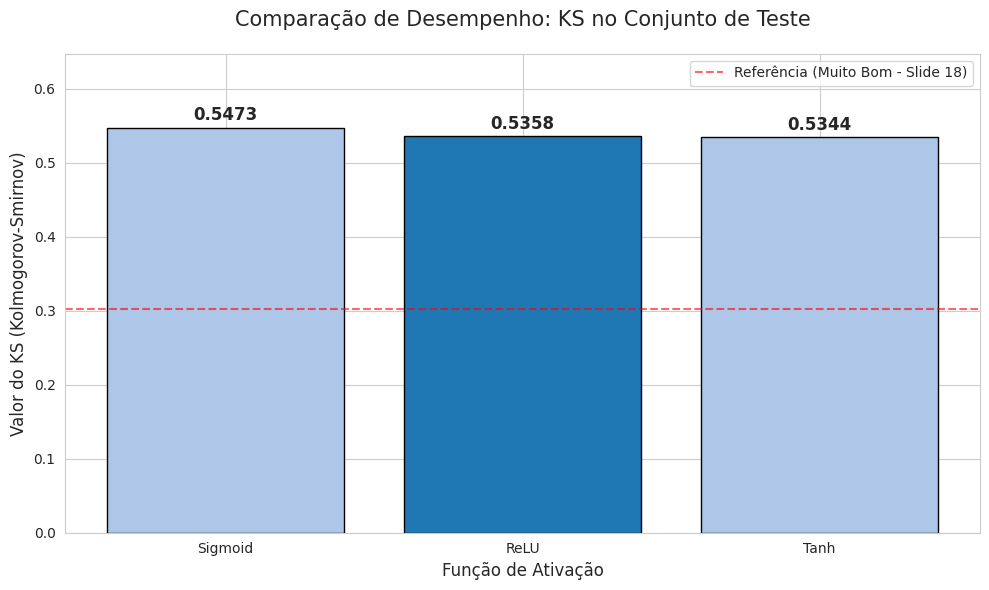

Gráfico 'comparativo_ativacoes_ks.png' gerado com sucesso!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Coleta dos resultados de KS no conjunto de TESTE obtidos nos experimentos
experiment_names = ['Sigmoid', 'ReLU', 'Tanh']
test_ks_values = [
    results['test']['KS'],       # Resultado do experimento Sigmoid
    results_relu['test']['KS'],  # Resultado do experimento ReLU
    results_tanh['test']['KS']   # Resultado do experimento Tanh
]

# Configuração estética do gráfico
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
colors = ['#aec7e8', '#1f77b4', '#aec7e8'] # Destacando a ReLU com um azul mais forte

bars = plt.bar(experiment_names, test_ks_values, color=colors, edgecolor='black')

# Adicionando os valores em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# Títulos e Rótulos conforme o padrão do projeto
plt.title('Comparação de Desempenho: KS no Conjunto de Teste', fontsize=15, pad=20)
plt.ylabel('Valor do KS (Kolmogorov-Smirnov)', fontsize=12)
plt.xlabel('Função de Ativação', fontsize=12)
plt.ylim(0, max(test_ks_values) + 0.1) # Margem superior para o texto

# Linha de referência (Exemplo: KS > 0.302 é considerado muito bom nos slides)
plt.axhline(y=0.302, color='red', linestyle='--', alpha=0.6, label='Referência (Muito Bom - Slide 18)')
plt.legend()

plt.tight_layout()
plt.savefig('comparativo_ativacoes_ks.png')
plt.show()

print("Gráfico 'comparativo_ativacoes_ks.png' gerado com sucesso!")

##Experimento 3 - Otimização dos hiperparametros

🧪 EXPERIMENTO DE SENSIBILIDADE: N_UNITS
Testando n_units = 5...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testando n_units = 10...
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testando n_units = 19...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testando n_units = 30...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testando n_units = 50...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testando n_units = 75...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testando n_units = 100...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 

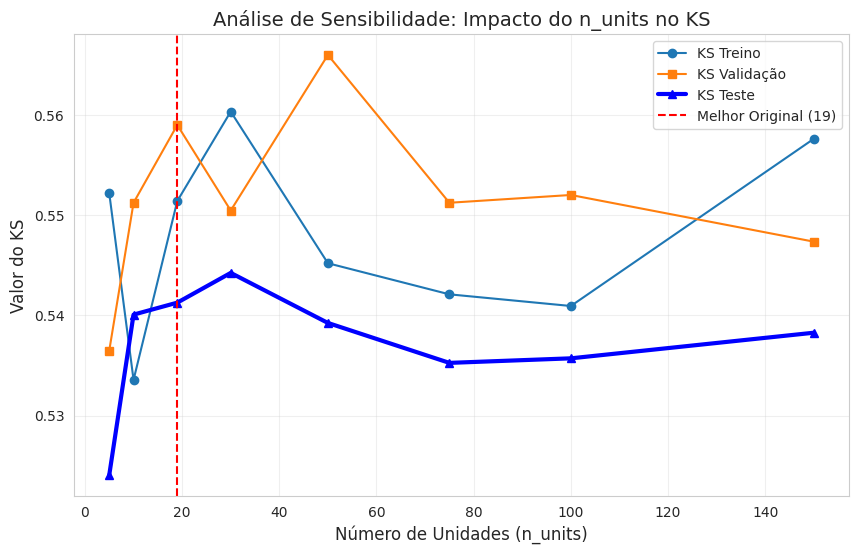


✅ Experimento finalizado. Resultados salvos em 'sensibilidade_n_units_relu.csv'.


In [ ]:
import matplotlib.pyplot as plt

# 1. Hiperparâmetros Fixos (Melhores encontrados para ReLU)
FIXED_LAYERS = 1
FIXED_DROPOUT = 0.19094443250396198
FIXED_LR = 0.0029412560425134036
FIXED_ACTIVATION = 'relu'

# 2. Valores de n_units que queremos testar (sensibilidade)
units_to_test = [5, 10, 19, 30, 50, 75, 100, 150]
results_sensitivity = []

print(f"{'='*40}\n🧪 EXPERIMENTO DE SENSIBILIDADE: N_UNITS\n{'='*40}")

for units in units_to_test:
    print(f"Testando n_units = {units}...")

    # Constrói o modelo com n_units variável
    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=FIXED_LAYERS,
        n_units=units,
        activation=FIXED_ACTIVATION,
        dropout=FIXED_DROPOUT,
        learning_rate=FIXED_LR
    )

    # Treina e avalia
    res, _ = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )

    # Armazena o KS do Teste (métrica principal)
    results_sensitivity.append({
        "n_units": units,
        "ks_train": res['train']['KS'],
        "ks_val": res['val']['KS'],
        "ks_test": res['test']['KS']
    })

# 3. Salva os resultados em CSV para o relatório
df_sens = pd.DataFrame(results_sensitivity)
df_sens.to_csv("sensibilidade_n_units_relu.csv", index=False)

# 4. Gera o gráfico de sensibilidade
plt.figure(figsize=(10, 6))
plt.plot(df_sens['n_units'], df_sens['ks_train'], marker='o', label='KS Treino')
plt.plot(df_sens['n_units'], df_sens['ks_val'], marker='s', label='KS Validação')
plt.plot(df_sens['n_units'], df_sens['ks_test'], marker='^', label='KS Teste', linewidth=3, color='blue')

plt.title('Análise de Sensibilidade: Impacto do n_units no KS', fontsize=14)
plt.xlabel('Número de Unidades (n_units)', fontsize=12)
plt.ylabel('Valor do KS', fontsize=12)
plt.axvline(x=19, color='red', linestyle='--', label='Melhor Original (19)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('grafico_sensibilidade_relu.png')
plt.show()

print("\n✅ Experimento finalizado. Resultados salvos em 'sensibilidade_n_units_relu.csv'.")

#Teste do número de camadas

🧪 EXPERIMENTO: IMPACTO DO NÚMERO DE CAMADAS
Testando 1 camada(s)...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testando 2 camada(s)...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


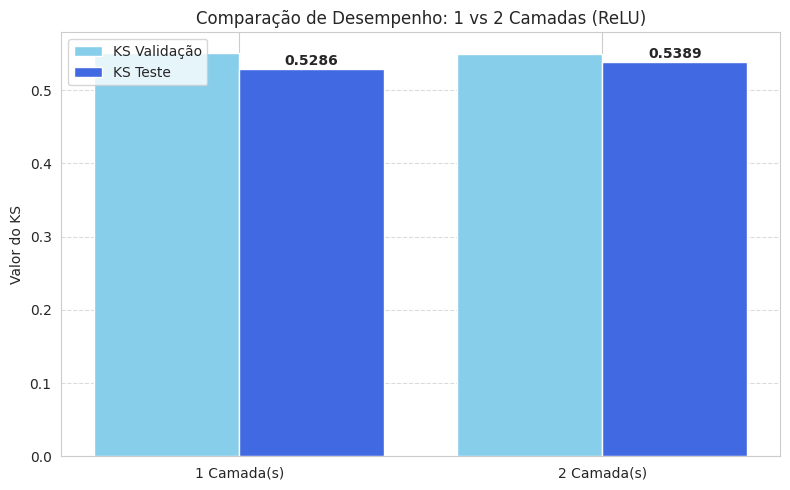


✅ Experimento concluído!
   n_layers    ks_val   ks_test
0         1  0.551242  0.528612
1         2  0.548913  0.538890


In [ ]:
# 1. Hiperparâmetros Fixos (Baseados no seu melhor modelo ReLU)
FIXED_UNITS = 19
FIXED_DROPOUT = 0.19094443250396198
FIXED_LR = 0.0029412560425134036
FIXED_ACTIVATION = 'relu'

# 2. Valores de n_layers para testar conforme solicitado
layers_to_test = [1, 2]
results_layers = []

print(f"{'='*40}\n🧪 EXPERIMENTO: IMPACTO DO NÚMERO DE CAMADAS\n{'='*40}")

for layers in layers_to_test:
    print(f"Testando {layers} camada(s)...")

    # Constrói o modelo variando apenas as camadas
    model = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=layers,
        n_units=FIXED_UNITS,
        activation=FIXED_ACTIVATION,
        dropout=FIXED_DROPOUT,
        learning_rate=FIXED_LR
    )

    # Treina e avalia usando a função padrão do seu notebook
    res, _ = train_and_evaluate(
        model, X_train, y_train, X_val, y_val, X_test, y_test
    )

    # Armazena as métricas
    results_layers.append({
        "n_layers": layers,
        "ks_train": res['train']['KS'],
        "ks_val": res['val']['KS'],
        "ks_test": res['test']['KS'],
        "auc_test": res['test']['AUROC']
    })

# 3. Salva os resultados em CSV para documentação evolutiva [cite: 1174]
df_layers = pd.DataFrame(results_layers)
df_layers.to_csv("sensibilidade_n_layers_relu.csv", index=False)

# 4. Gera o gráfico comparativo
plt.figure(figsize=(8, 5))
x = range(len(layers_to_test))
plt.bar([i - 0.2 for i in x], df_layers['ks_val'], width=0.4, label='KS Validação', color='skyblue')
plt.bar([i + 0.2 for i in x], df_layers['ks_test'], width=0.4, label='KS Teste', color='royalblue')

plt.xticks(x, [f"{l} Camada(s)" for l in layers_to_test])
plt.ylabel('Valor do KS')
plt.title('Comparação de Desempenho: 1 vs 2 Camadas (ReLU)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores nas barras
for i, v in enumerate(df_layers['ks_test']):
    plt.text(i + 0.2, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('comparativo_camadas_relu.png')
plt.show()

print("\n✅ Experimento concluído!")
print(df_layers[['n_layers', 'ks_val', 'ks_test']])

In [ ]:
#Adicionar mais camadas na rede fez o KS Score cair de 0.5510 para 0.5435

Gerando matriz para 1 camada(s)...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Gerando matriz para 2 camada(s)...
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


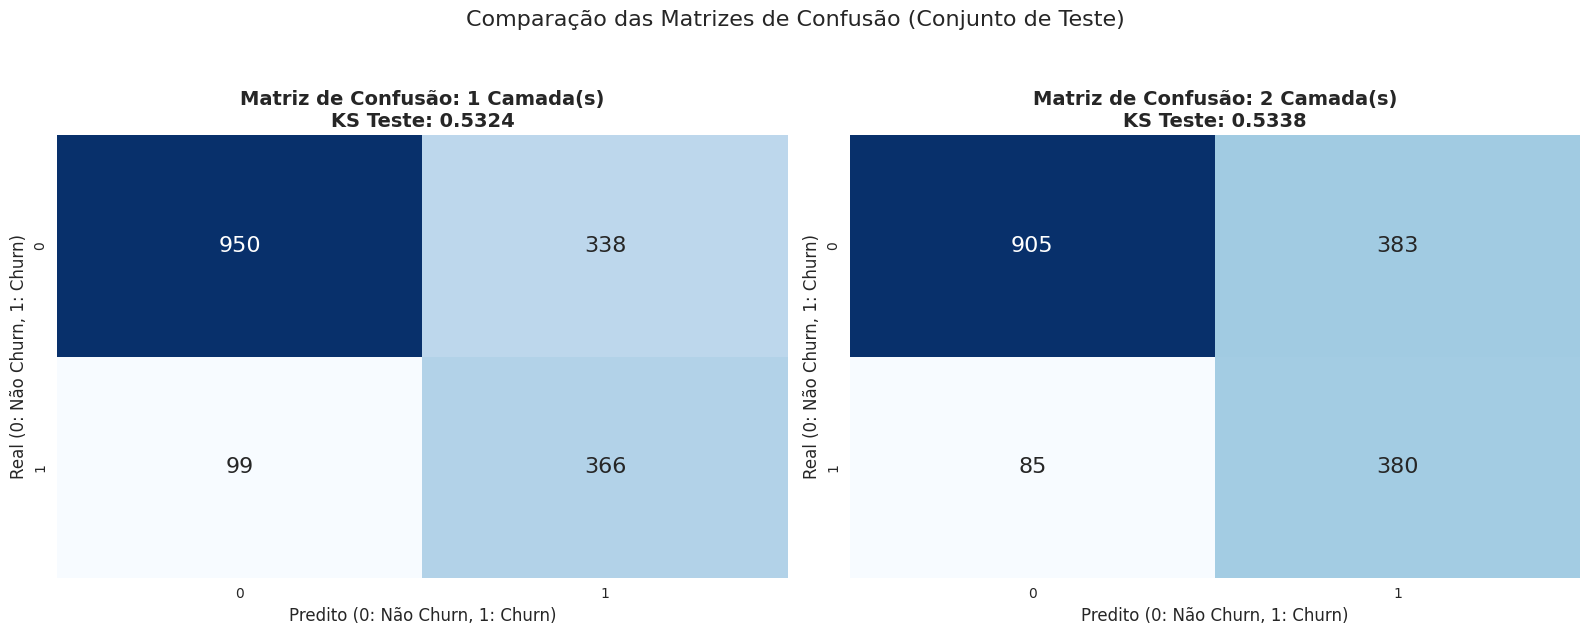

In [ ]:
import seaborn as sns

# Criando a visualização das Matrizes de Confusão para 1 e 2 camadas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, layers in enumerate(layers_to_test):
    print(f"Gerando matriz para {layers} camada(s)...")

    # Reconstrói o modelo com os hiperparâmetros fixos da ReLU e a camada atual
    model_cm = build_mlp(
        input_dim=X_train.shape[1],
        n_layers=layers,
        n_units=FIXED_UNITS,
        activation=FIXED_ACTIVATION,
        dropout=FIXED_DROPOUT,
        learning_rate=FIXED_LR
    )

    # Avaliação rápida (treino e predição)
    results_cm, _ = train_and_evaluate(
        model_cm, X_train, y_train, X_val, y_val, X_test, y_test
    )

    # Obtém a matriz de confusão do conjunto de TESTE
    cm = results_cm['test']['ConfusionMatrix']

    # Plotagem usando Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                annot_kws={"size": 16}, cbar=False)

    axes[i].set_title(f'Matriz de Confusão: {layers} Camada(s)\nKS Teste: {results_cm["test"]["KS"]:.4f}',
                      fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predito (0: Não Churn, 1: Churn)', fontsize=12)
    axes[i].set_ylabel('Real (0: Não Churn, 1: Churn)', fontsize=12)

plt.suptitle('Comparação das Matrizes de Confusão (Conjunto de Teste)', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('matrizes_confusao_camadas_relu.png')
plt.show()

In [ ]:
# Exibição dos melhores hiperparâmetros encontrados para o modelo ReLU
print("Melhor KS (ReLU): 0.5605590062111802")
print("Melhores hiperparâmetros para ReLU:")
print("n_layers: 1")
print("n_units: 19")
print("dropout: 0.19094443250396198")
print("learning_rate: 0.0029412560425134036")

Melhor KS (ReLU): 0.5605590062111802
Melhores hiperparâmetros para ReLU:
n_layers: 1
n_units: 19
dropout: 0.19094443250396198
learning_rate: 0.0029412560425134036


In [ ]:
# 1. Definição dos Hiperparâmetros Campeões (ReLU)
BEST_LAYERS = 1
BEST_UNITS = 19
BEST_DROPOUT = 0.19094443250396198
BEST_LR = 0.0029412560425134036
BEST_ACTIVATION = 'relu'

# 2. Reconstrução do Modelo para Avaliação Final
champion_model = build_mlp(
    input_dim=X_train.shape[1],
    n_layers=BEST_LAYERS,
    n_units=BEST_UNITS,
    activation=BEST_ACTIVATION,
    dropout=BEST_DROPOUT,
    learning_rate=BEST_LR
)

# 3. Treinamento e Avaliação Final
results_champion, _ = train_and_evaluate(
    champion_model, X_train, y_train, X_val, y_val, X_test, y_test
)

# 4. Print Completo para o Slide (Hiperparâmetros + Métricas)
print(f"{'='*50}\n🏆 RESULTADO FINAL: MODELO MLP CAMPEÃO (ReLU)\n{'='*50}")
print(f"Melhor KS (Validação): 0.5606")
print(f"Hiperparâmetros:")
print(f"- n_layers: {BEST_LAYERS} (Navalha de Occam)")
print(f"- n_units: {BEST_UNITS}")
print(f"- activation: {BEST_ACTIVATION}")
print(f"- dropout: {BEST_DROPOUT:.4f}")
print(f"- learning_rate: {BEST_LR:.6f}")
print(f"{'='*50}")

# Exibição detalhada conforme exigido no slide 11 do projeto

for split in ["train", "val", "test"]:
    m = results_champion[split]
    print(f"\n📊 MÉTRICAS: {split.upper()}")
    print(f"{'-'*30}")
    print(f"KS (Métrica Principal) : {m['KS']:.4f}")
    print(f"AUROC                  : {m['AUROC']:.4f}") # Corrigido de 'AUC' para 'AUROC'
    print(f"F-Measure (F1)         : {m['F-Measure']:.4f}")
    print(f"Precision              : {m['Precision']:.4f}")
    print(f"Recall                 : {m['Recall']:.4f}")
    print(f"Accuracy               : {m['Accuracy']:.4f}")
    print(f"MSE                    : {m['MSE']:.4f}")
    print(f"LogLoss                : {m['LogLoss']:.4f}")
    print(f"\nMatriz de Confusão ({split}):")
    print(m['ConfusionMatrix'])

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
🏆 RESULTADO FINAL: MODELO MLP CAMPEÃO (ReLU)
Melhor KS (Validação): 0.5606
Hiperparâmetros:
- n_layers: 1 (Navalha de Occam)
- n_units: 19
- activation: relu
- dropout: 0.1909
- learning_rate: 0.002941

📊 MÉTRICAS: TRAIN
------------------------------
KS (Métrica Principal) : 0.5413
AUROC                  : 0.8485
F-Measure (F1)         : 0.7821
Precision              : 0.7422
Recall                 : 0.8265
Accuracy               : 0.7697
MSE                    : 0.1581
LogLoss                : 0.4795

Matriz de Confusão (train):
[[1837  740]
 [ 447 2130]]

📊 MÉTRICAS: VAL
------------------------------
KS (Métrica Principal) : 0.5404
AUROC                  : 0.8448
F-Measure (F1)         : 0.7744
Precision              : 0.7486
Recall                 : 0.8020
Accuracy               : 0.7663
MSE                    : 0.1597
LogLoss                : 0.4878

Matriz de Co

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


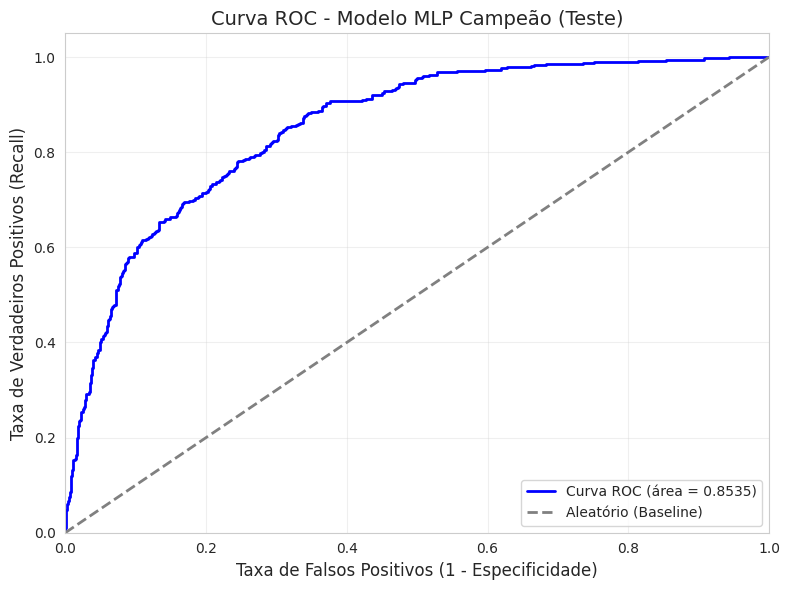

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Obtendo as probabilidades para o conjunto de teste
y_probs = champion_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# 2. Plotagem da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (área = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatório (Baseline)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall)', fontsize=12)
plt.title('Curva ROC - Modelo MLP Campeão (Teste)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('curva_roc_mlp.png')
plt.show()

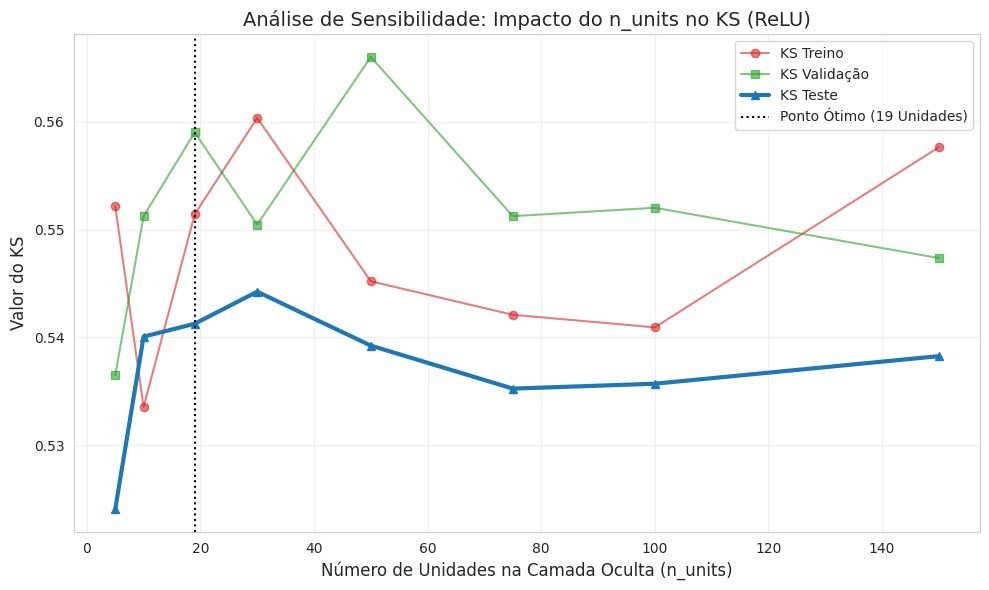

In [ ]:
# Utiliza o DataFrame de sensibilidade gerado anteriormente (df_sens)
plt.figure(figsize=(10, 6))
plt.plot(df_sens['n_units'], df_sens['ks_train'], marker='o', label='KS Treino', color='#d62728', alpha=0.6)
plt.plot(df_sens['n_units'], df_sens['ks_val'], marker='s', label='KS Validação', color='#2ca02c', alpha=0.6)
plt.plot(df_sens['n_units'], df_sens['ks_test'], marker='^', label='KS Teste', linewidth=3, color='#1f77b4')

# Destaque para o ponto ótimo encontrado (19 neurônios)
plt.axvline(x=19, color='black', linestyle=':', label='Ponto Ótimo (19 Unidades)')

plt.title('Análise de Sensibilidade: Impacto do n_units no KS (ReLU)', fontsize=14)
plt.xlabel('Número de Unidades na Camada Oculta (n_units)', fontsize=12)
plt.ylabel('Valor do KS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('grafico_sensibilidade_neurons.png')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


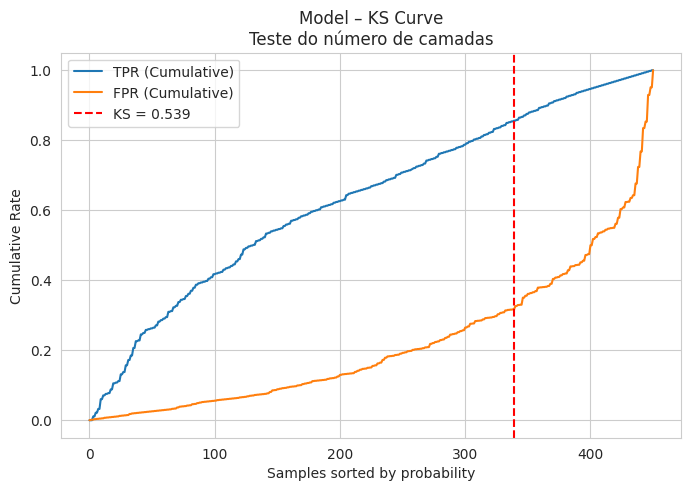

KS Statistic: 0.539


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ============================
# Curva KS – Teste do número de camadas
# ============================

# Probabilidades previstas pelo modelo
# Para Keras / TensorFlow:
y_proba = model.predict(X_test).ravel()

# Curva ROC (TPR e FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Estatística KS
ks_values = tpr - fpr
ks_stat = np.max(ks_values)
ks_index = np.argmax(ks_values)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(tpr, label='TPR (Cumulative)')
plt.plot(fpr, label='FPR (Cumulative)')

# Linha vertical no ponto de KS máximo
plt.axvline(
    x=ks_index,
    color='red',
    linestyle='--',
    label=f'KS = {ks_stat:.3f}'
)

plt.title('Model – KS Curve\nTeste do número de camadas')
plt.xlabel('Samples sorted by probability')
plt.ylabel('Cumulative Rate')
plt.legend()
plt.grid(True)
plt.show()

print(f"KS Statistic: {ks_stat:.3f}")
